In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [31]:
dataset_path = "/PlantVillage"
BATCH_SIZE = 32
IMAGE_SIZE = 256
channels = 3
epochs = 10 #Total 50 complete dataset passes to the model 

In [32]:

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred', 
    label_mode= 'int', 
    image_size= (256, 256), 
    batch_size= BATCH_SIZE, 
    shuffle=True
)


Found 2152 files belonging to 3 classes.


In [33]:
class_names = image_dataset.class_names
print("Class Names:", class_names)

Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [34]:
len(image_dataset)

68

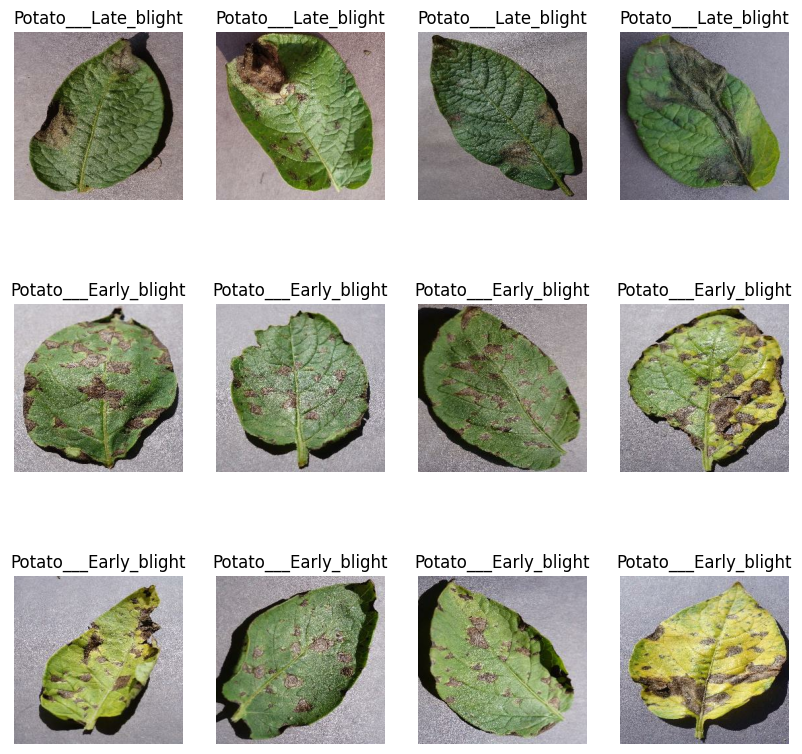

In [35]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in image_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [36]:
train_size = 0.8
len(image_dataset)*train_size

54.400000000000006

In [37]:
test_dataset = image_dataset.skip(54)
len(test_dataset)

14

In [38]:
val_size = 0.1
test_size = 0.1

len(image_dataset)*val_size

6.800000000000001

In [39]:
val_dataset = test_dataset.take(6)
len(val_dataset)

6

In [40]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [41]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    
train_ds, val_ds, test_ds = get_dataset_partition_tf(ds=image_dataset)

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Fixed 'layers.experimental.preprocessing.Resizing'
    layers.Rescaling(1.0/255)                 # Fixed 'layers.experimental.preprocessing.Rescaling'
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2)                     # Randomly rotate images by 20% (0.2 * 2π radians)
])

In [45]:
input_shape = ( BATCH_SIZE ,IMAGE_SIZE, IMAGE_SIZE, channels)
n_calsses = 3
model = models.Sequential([
    resize_and_rescale, 
    data_augmentation, 
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape), 
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(n_calsses, activation='softmax') 
])

model.build(input_shape=input_shape)

C:\Users\mohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [46]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape         ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)    │ (32, 256, 256, 3)    │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ sequential_5 (Sequential)    │ (32, 256, 256, 3)    │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_12 (Conv2D)           │ (32, 254, 254, 32)   │         896 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_12             │ (32, 127, 127, 32)   │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_13 (Conv2D)           │ (32, 125, 125, 64)   │      18,496 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_13             │ (32, 62, 62, 64)     │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_14 (Conv2D)           │ (32, 60, 60, 64)     │      36,928 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_14             │ (32, 30, 30, 64)     │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_15 (Conv2D)           │ (32, 28, 28, 64)     │      36,928 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_15             │ (32, 14, 14, 64)     │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_16 (Conv2D)           │ (32, 12, 12, 64)     │      36,928 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_16             │ (32, 6, 6, 64)       │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ conv2d_17 (Conv2D)           │ (32, 4, 4, 64)       │      36,928 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ max_pooling2d_17             │ (32, 2, 2, 64)       │           0 │
│ (MaxPooling2D)               │                      │             │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ flatten_1 (Flatten)          │ (32, 256)            │           0 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_2 (Dense)              │ (32, 64)             │      16,448 │
├──────────────────────────────┼──────────────────────┼─────────────┤
│ dense_3 (Dense)              │ (32, 3)              │         195 │
└──────────────────────────────┴──────────────────────┴─────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4718 - loss: 0.9129 - val_accuracy: 0.6198 - val_loss: 0.8169
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6754 - loss: 0.7257 - val_accuracy: 0.7292 - val_loss: 0.5719
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7593 - loss: 0.5263 - val_accuracy: 0.7500 - val_loss: 0.6000
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8255 - loss: 0.4208 - val_accuracy: 0.8854 - val_loss: 0.2910
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8793 - loss: 0.3048 - val_accuracy: 0.8906 - val_loss: 0.2497
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9341 - loss: 0.1806 - val_accuracy: 0.8646 - val_loss: 0.2919
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9234 - loss: 0.1911 - val_accuracy: 0.8906 - val_loss: 0.2155
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9319 - loss: 0.1861 - val_accuracy: 0.9792 - v

In [55]:
score = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - accuracy: 0.9632 - loss: 0.0868


In [56]:
score

[0.10766094923019409, 0.94921875]

In [57]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [58]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [60]:
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

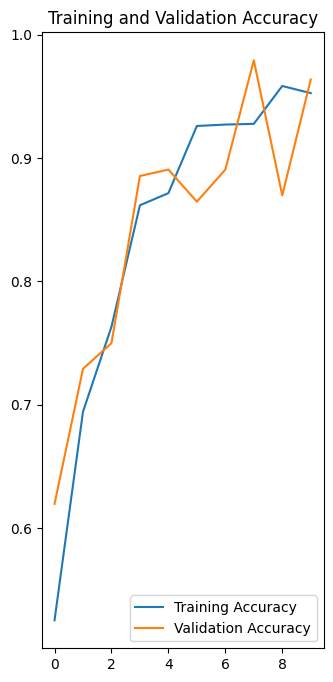

In [64]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


first image to predit: 


TypeError: only integer scalar arrays can be converted to a scalar index

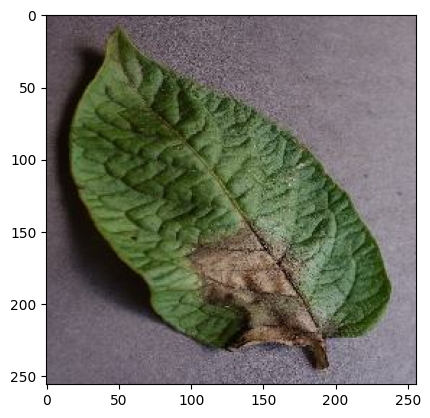

In [66]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = image_batch[0].numpy()

    print('first image to predit: ')
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predict label:", class_names[np.argmax(batch_prediction[0])])
    